[Guide](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

# Install PyTorch

In [1]:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Imports

In [2]:
import torchvision
from PIL import Image
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt

# Load Model

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Define class names

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush']

# Prediction

In [5]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

# Define Pipeline

In [6]:
def object_detection_api(img_path, threshold=0.9, rect_th=2, text_size=1, text_th=2):
    found = []
    boxes, pred_cls, pred_score = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        if pred_cls[i] == 'person':
            x,y = boxes[i][0]
            text = f'{pred_cls[i]} - {round(pred_score[i]*100)}%'
            cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
            cv2.putText(img,pred_cls[i], (int(x+5*text_size),int(y+30*text_size)),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th) # Write the prediction class
            cv2.putText(img,f'{round(pred_score[i]*100)}%', (int(x+5*text_size),int(y+70*text_size)),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)
            found.append((pred_cls[i],f'{round(pred_score[i]*100)}%',tuple(boxes[i])))
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return found

# Run Object Detection

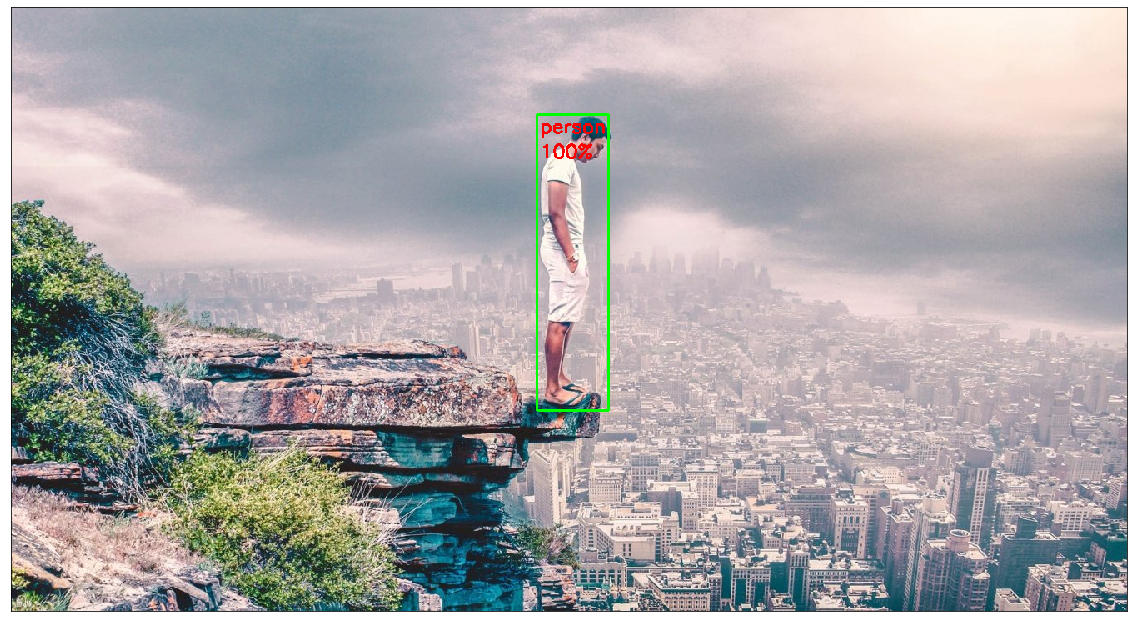

[('person', '100%', ((631.3351, 130.07675), (717.47784, 485.35806)))]

In [7]:
object_detection_api('./../src/imgs/one.jpg', text_size=0.75)

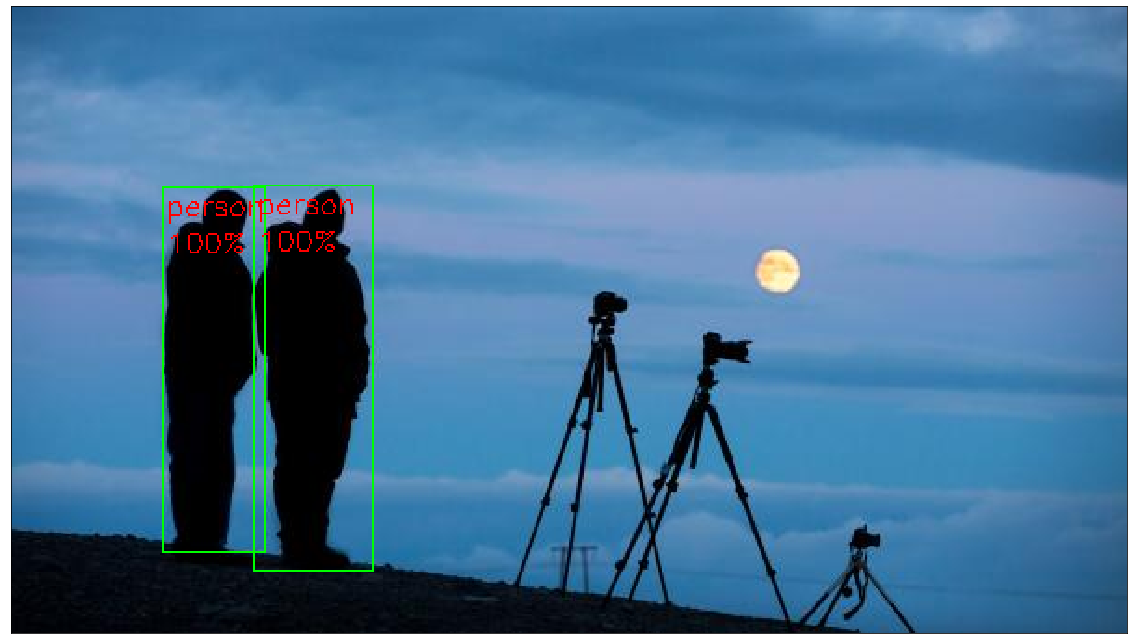

[('person', '100%', ((81.2607, 97.887726), (136.37242, 293.4127))),
 ('person', '100%', ((130.04599, 96.43442), (194.3818, 303.32666)))]

In [8]:
object_detection_api('./../src/imgs/two.jpg', rect_th=1, text_size=0.5, text_th=1)

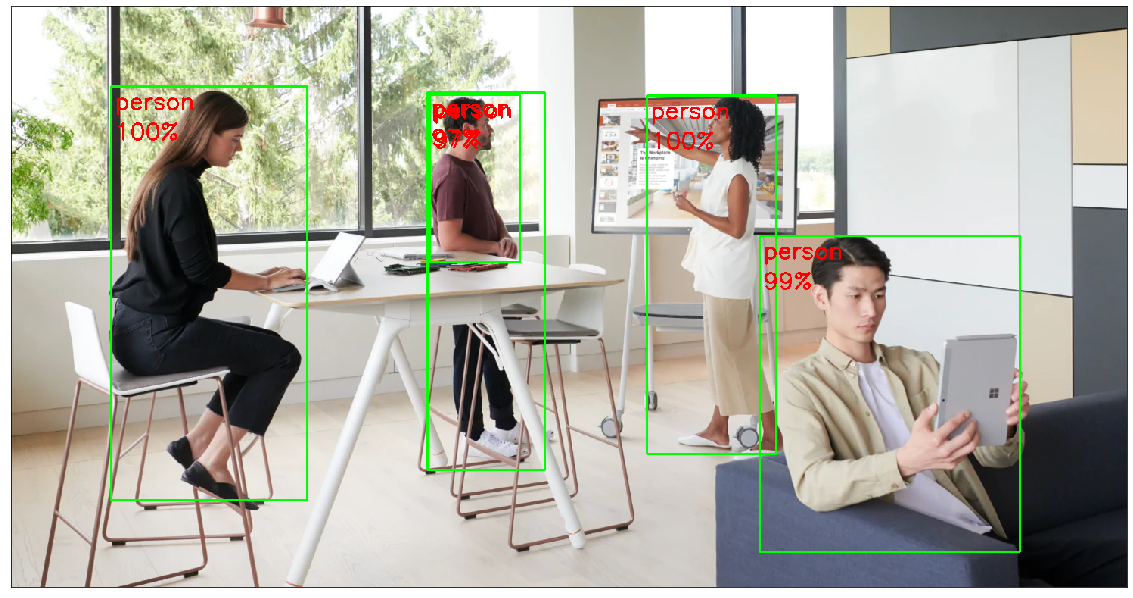

[('person', '100%', ((132.3423, 107.643425), (391.8896, 653.35785))),
 ('person', '100%', ((840.3427, 119.22844), (1011.32, 592.28455))),
 ('person', '99%', ((989.6262, 304.08792), (1333.1335, 721.15845))),
 ('person', '97%', ((553.4591, 118.62975), (672.42816, 339.99664))),
 ('person', '97%', ((550.62665, 115.75061), (705.8189, 613.7574)))]

In [9]:
object_detection_api('./../src/imgs/three.webp')

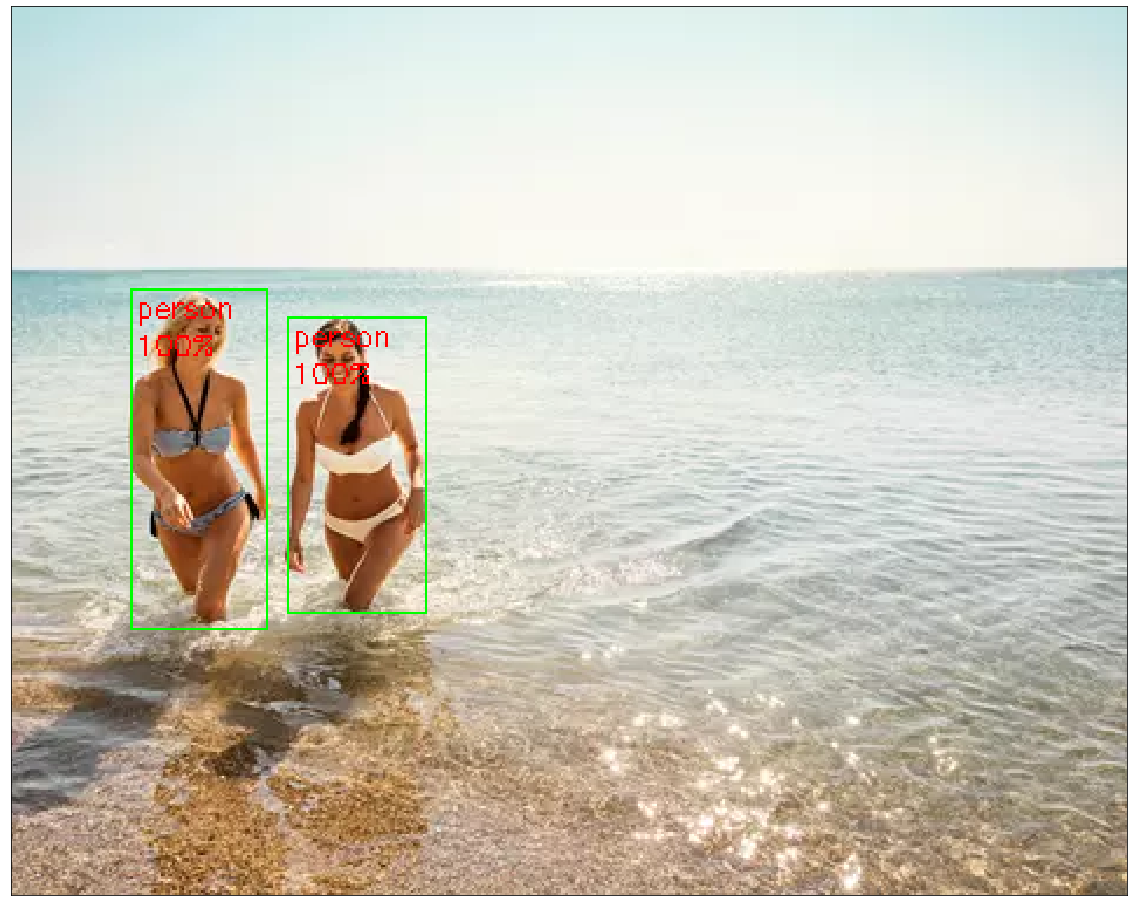

[('person', '100%', ((51.114872, 121.21195), (109.5023, 266.79047))),
 ('person', '100%', ((118.453316, 133.52379), (177.66011, 259.51447)))]

In [10]:
object_detection_api('./../src/imgs/four.webp', rect_th=1, text_size=0.4, text_th=1)

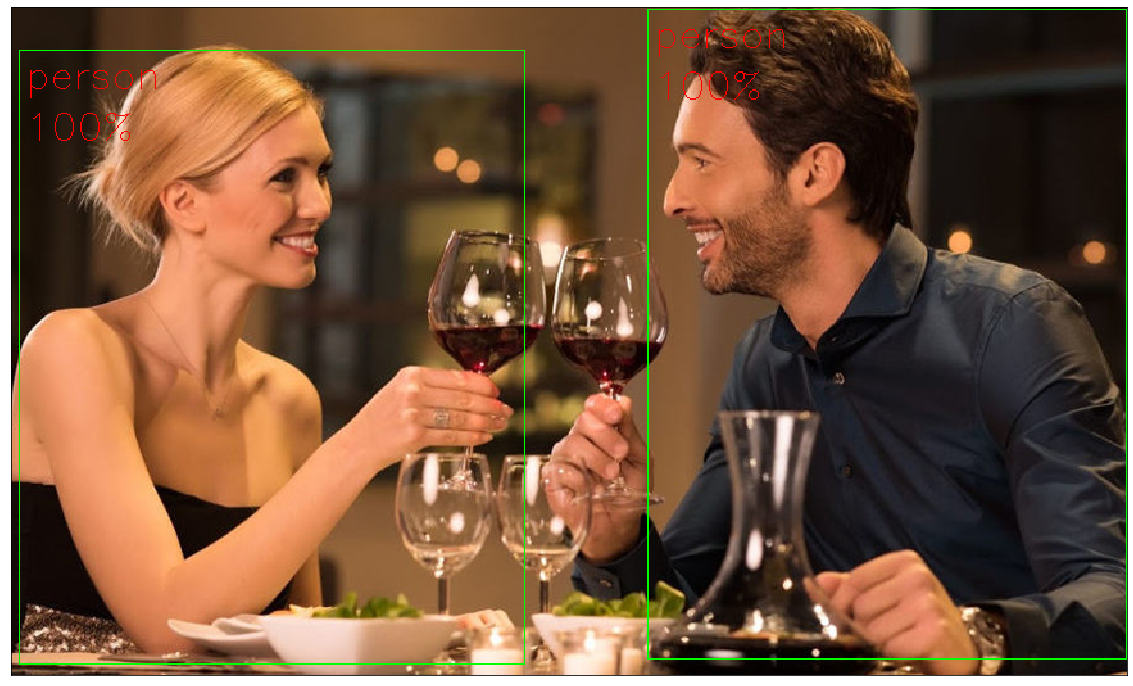

[('person', '100%', ((496.43433, 2.7127647), (869.44165, 508.85498))),
 ('person', '100%', ((6.618313, 34.756893), (400.32004, 512.0117)))]

In [11]:
object_detection_api('./../src/imgs/five.png', rect_th=1, text_th=1)

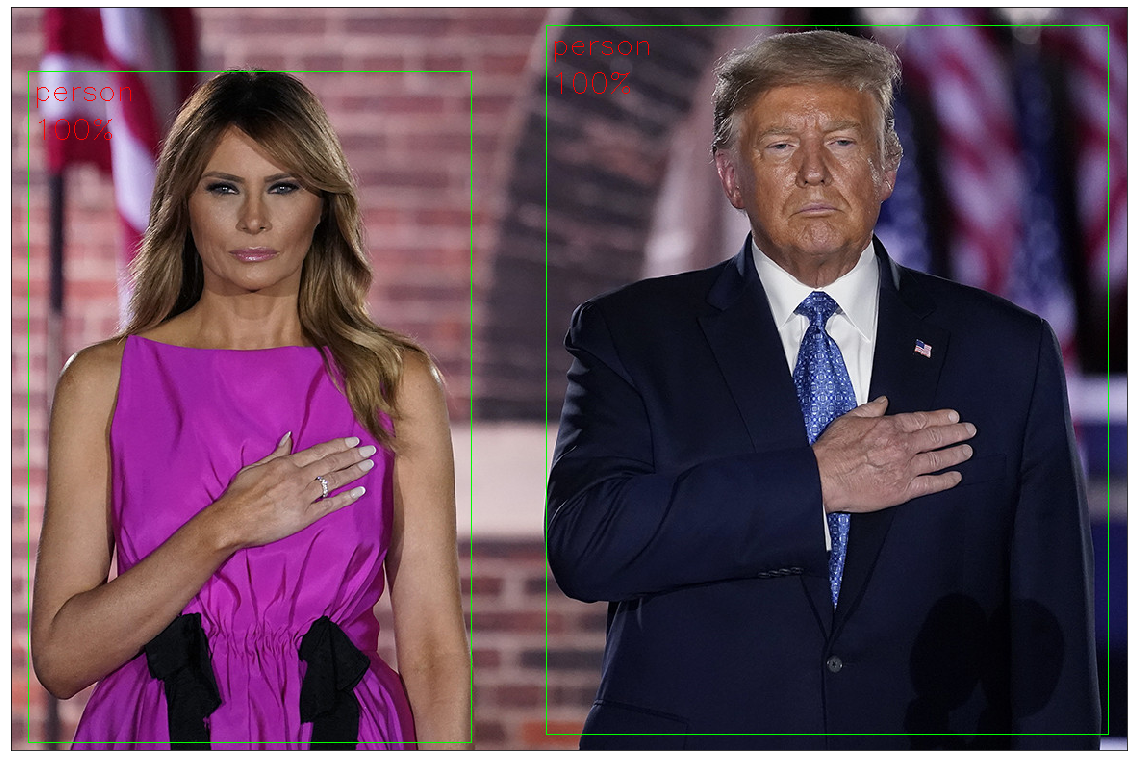

[('person', '100%', ((18.828362, 68.92328), (478.91565, 765.80896))),
 ('person', '100%', ((556.49176, 20.768625), (1140.9768, 756.2322)))]

In [12]:
object_detection_api('./../src/imgs/six.jpg', rect_th=1, text_th=1)